In [2]:
# %% ============================================================================
#
# Classification Models for prediction of protein corona (PC) based on nanoparticle (NP) physicochemical properties and experimental conditions.
# Author: Alexa Canchola
# Advisor: Wei-Chun Chou
# Date: April 21, 2025
# ==============================================================================
"""
This script builds and evaluates five machine learning classification models:
- K-Nearest Neighbors (k-NN)
- Random Forest (RF)
- Support Vector Machine (SVM)
- LightGBM
- XGBoost
For the prediction of Apolipoprotein E (APOE), Apolipoprotein B-100 (APOB), Complement Component C3 (CO3), and Clusterin (CLUS) adsoprtion
"""
# %% ============================================================================
# Install Libraries as Necessary
# ============================================================================

!pip install scikit-learn lightgbm scikit-optimize xgboost
!pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 2.5 MB/s eta 0:00:00


In [3]:
# %% ============================================================================
# Import Required Libraries
# ============================================================================
# Standard Libraries for Data Handling
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# SKLearn - Model Selection & Evaluation
# Used for model development, cross validation, and evaluating model performance
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve
    )
from sklearn.model_selection import StratifiedKFold, cross_validate, train_test_split

#Imbalance-Learn
# Used for Oversampling techniques like SMOTE and creating pipelines
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline


#Gradient Boosting Libraries
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings('ignore')

# Bayesian Hyperparameter Optimization
# For optimizing model hyperparameters using Bayesian Search
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical

In [4]:
# %% ============================================================================
#Import & Preprocess Data
# ============================================================================
from google.colab import files
import pandas as pd
import io

# Load Data
uploaded = files.upload() # prediction_model_data_human_only.csv
file_name = list(uploaded.keys())[0]
PC = pd.read_csv(io.BytesIO(uploaded[file_name]))

Saving prediction_model_data_human_only(1).csv to prediction_model_data_human_only(1).csv


In [5]:
# Removing rows with any missing values
PC.dropna(inplace=True)
PC.head()

,Type,Subtype,Mod_Charge,Shape,Size_Group,ZP_Group,ZP_Charge,In_Time,Shaking,Species,APOE,APOB,CO3,CLUS
0,Inorganic,Silica,No Modification,Sphere,100~150,-50~-10,Negative,30~60,Y,Human,Present,Present,Present,Present
1,Inorganic,Silica,No Modification,Sphere,>150,-50~-10,Negative,30~60,Y,Human,Present,Present,Present,Present
2,Inorganic,Silica,Positive,Sphere,100~150,-50~-10,Negative,30~60,Y,Human,Present,Present,Present,Present
3,Inorganic,Silica,Positive,Sphere,>150,-10~+10,Neutral,30~60,Y,Human,Present,Present,Present,Present
4,Inorganic,Silica,Negative,Sphere,100~150,-50~-10,Negative,30~60,Y,Human,Present,Present,Present,Present


In [5]:
PC

,Type,Subtype,Mod_Charge,Shape,Size_Group,ZP_Group,ZP_Charge,In_Time,Shaking,Species,APOE,APOB,CO3,CLUS
0,Inorganic,Silica,No Modification,Sphere,100~150,-50~-10,Negative,30~60,Y,Human,Present,Present,Present,Present
1,Inorganic,Silica,No Modification,Sphere,>150,-50~-10,Negative,30~60,Y,Human,Present,Present,Present,Present
2,Inorganic,Silica,Positive,Sphere,100~150,-50~-10,Negative,30~60,Y,Human,Present,Present,Present,Present
3,Inorganic,Silica,Positive,Sphere,>150,-10~+10,Neutral,30~60,Y,Human,Present,Present,Present,Present
4,Inorganic,Silica,Negative,Sphere,100~150,-50~-10,Negative,30~60,Y,Human,Present,Present,Present,Present
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
576,Inorganic,Metal Oxide,Neutral,Sphere,<50,<-50,Negative,30~60,N,Human,Absent,Present,Absent,Absent
577,Inorganic,Metal Oxide,Neutral,Sphere,<50,<-50,Negative,30~60,N,Human,Present,Present,Absent,Absent
578,Inorganic,Metal Oxide,Neutral,Sphere,<50,<-50,Negative,30~60,N,Human,Absent,Present,Absent,Absent
579,Inorganic,Metal Oxide,Neutral,Sphere,<50,<-50,Negative,30~60,N,Human,Present,Present,Absent,Absent


In [6]:
# Mapping string categories to numerical values
encoding_mappings = {
    'Size_Group': {"<50": 0, "50~100": 1, "100~150": 2,">150":3},
    'In_Time': {"<30": 0, "30~60": 1, ">60": 2},
    'ZP_Group': {"<-50": 0, "-50~-10": 1,"-10~+10":2,"+10~+50":3,">+50":4},
    'APOE': {"Present": 0, "Absent": 1},
    'APOB': {"Present": 0, "Absent": 1},
    'CO3': {"Present": 0, "Absent": 1},
    'CLUS': {"Present": 0, "Absent": 1}
}

#Apply encoding to the dataframe
for col, mapping in encoding_mappings.items():
    PC[col] = PC[col].replace(mapping)

In [7]:
# One-Hot Encoding for categorical variables
PC_encoded = pd.get_dummies(PC, columns=['Type', 'Subtype', 'Mod_Charge','ZP_Charge','Shaking'], drop_first=True)

In [8]:
# Define relevant features for the models
X = PC_encoded[['Size_Group', 'ZP_Group', 'In_Time'] + [col for col in PC_encoded.columns if col.startswith(('Type', 'Subtype','Mod_Charge','ZP_Charge','Shaking'))]]

# Split data into Training and Test sets for each target
X_train, X_test_full, y_train_dict, y_test_dict = {}, {}, {}, {}
targets = ['APOE', 'APOB', 'CO3', 'CLUS']

for target in targets:
    y = PC_encoded[target]
    X_train[target], X_test_full[target], y_train_dict[target], y_test_dict[target] = train_test_split(X, y, test_size=0.3, random_state=32, stratify=y)

In [9]:
# %% ============================================================================
# Model Hyperparameter Optimization: Define Parameter Space for Bayesian Optimization
# ============================================================================

# KNN Parameter Space
param_space_KNN = {
    'clf__n_neighbors': [3, 5, 7],  # Number of neighbors to use for kneighbors queries
    'clf__weights': ['uniform', 'distance'],  # Weigh points in a neighborhood equally (uniform) or by inverse of distance (distance)
    'clf__metric': ['minkowski', 'euclidean', 'manhattan', 'chebyshev'], # Used for distance computation
    'clf__algorithm': ['auto', 'ball_tree', 'kd_tree'],  # Algorithm used to compute nearest neighbor
    'clf__leaf_size': [20, 30, 40, 50],  # Size of leaf nodes in tree algorithms (BallTree or KDTree)
    'clf__n_jobs': [-1],  # Use all cores for parallel processing
}

# LightGBM Parameter Space
param_space_LGBM = {
    'clf__num_leaves': (15, 63),  # Controls tree complexity
    'clf__max_depth': (3, 15),  # Limits tree depth to prevent overfitting
    'clf__learning_rate': (0.01, 0.3, 'log-uniform'),  # Boosting learning rate
    'clf__min_child_samples': (10, 50),  # Min data in child node
    'clf__feature_fraction': (0.7, 1.0),  # Fraction of features per tree
    'clf__bagging_fraction': (0.7, 1.0),  # Row sampling ratio
    'clf__bagging_freq': (1, 10),  # Frequency of bagging
    'clf__class_weight': ['balanced'],  # Automatic class weighing for imbalanced samples
    'clf__verbosity': [-1]  # Suppresses extraneous warnings and information in output
}

# Random Forest Parameter Space
param_space_RF = {
    'clf__n_estimators': Integer(1,5),  # Limit the number of trees
    'clf__max_depth': Integer(1,5),  # Limits tree depth to prevent overfitting
    'clf__max_features': Categorical(['sqrt', 'log2']),  # Number of features to consider when calculating best split
    'clf__class_weight': ['balanced'],  # Maintain class weight
    'clf__min_samples_split': Integer(1,10),  # Minimum number of samples required to split a node
    'clf__min_samples_leaf': Integer(1,5)  # Min number of samples required to be at a leaf node
}


# SVM Parameter Space
param_space_SVM = {
    'clf__C': Real(0.001, 100, prior='log-uniform'),  # Regularization strength
    'clf__class_weight': Categorical([None, 'balanced']),  # Handle class imbalance
}

# XGBoost Parameter Space
param_space_XGBoost = {
    'clf__max_depth': (3, 15),  # Limit depth to prevent overfitting
    'clf__learning_rate': (0.01, 0.3, 'log-uniform'),  # Learning rate
    'clf__min_child_weight': (1, 50),  # Min data in child node
    'clf__gamma': (0, 1),  # Minimum loss reduction to split a node
    'clf__scale_pos_weight': (1, 10),  # Positive class weight scaling (for imbalanced data)
    'clf__lambda_l2': (0.0, 1.0, 'uniform'),  # L2 regularization term
    'clf__subsample': (0.5, 1.0),  # Fraction of samples for each tree
    'clf__colsample_bytree': (0.5, 1.0),  # Fraction of features per tree
    'clf__colsample_bylevel': (0.5, 1.0)  # Fraction of features per level
}


In [10]:
# %% ============================================================================
# Define Model Evaluation Functions
# ==============================================================================

# Function to evaluate model metrics
def model_metrics(y_true, y_pred, y_pred_prob):
  return {
    "auc": roc_auc_score(y_true, y_pred_prob),
    "accuracy": accuracy_score(y_true, y_pred),
    "precision": precision_score(y_true, y_pred),
    "recall": recall_score(y_true, y_pred),
    "f1": f1_score(y_true, y_pred)}

# Function to calculate average outer results from nested cross-validation

def calculate_ncv_avg_outer(results):
  metrics = ["auc","accuracy","precision","recall","f1"]
  for metric in metrics:
    values = [result[metric] for result in results]
    print(f"{metric.upper()}:{np.mean(values):.3f}±{np.std(values):.3f}")

In [11]:
# k-NN
def nested_cv_bayes_KNN(X_train, y_train, param_space, scoring='roc_auc', n_iter=5):
    # Define inner and outer cross-validation
    outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=32)
    inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=32)

    # Pipeline with SMOTE and KNeighborsClassifier
    pipeline = Pipeline([
        ('smote', SMOTE(random_state=32)),
        ('clf', KNeighborsClassifier())
    ])

    # Bayesian optimization within the pipeline
    bayes_search = BayesSearchCV(
        estimator=pipeline,
        search_spaces=param_space_KNN,
        cv=inner_cv,
        scoring=scoring,
        n_iter=n_iter,  # Reduced iterations for faster tuning
        n_jobs=-1,
        random_state=32
    )

    # Outer cross-validation
    cv_results = cross_validate(
        bayes_search, X_train, y_train, cv=outer_cv, scoring=scoring, return_estimator=True, n_jobs=-1
    )

    # Fit BayesSearchCV to the full training set to find the best model and parameters
    bayes_search.fit(X_train, y_train)
    best_estimator = bayes_search.best_estimator_
    best_score = bayes_search.best_score_
    best_params = bayes_search.best_params_

    # Collect classification reports, ROC-AUC scores, & model metric for outer test folds
    classification_reports = []
    roc_auc_scores = []
    outer_results = []

    for i, estimator in enumerate(cv_results['estimator']):
        # Obtain the outer test indices for each fold
        outer_train_idx, outer_test_idx = list(outer_cv.split(X_train, y_train))[i]
        X_outer_test, y_outer_test = X_train.iloc[outer_test_idx], y_train.iloc[outer_test_idx]

        # Predict and score on the outer test fold
        y_pred = estimator.predict(X_outer_test)
        y_prob = estimator.predict_proba(X_outer_test)[:, 1]

        metrics = model_metrics(y_outer_test, y_pred, y_prob)
        outer_results.append(metrics)

        # Store ROC-AUC score and classification report for this fold
        roc_auc_scores.append(roc_auc_score(y_outer_test, y_prob))
        classification_reports.append(classification_report(y_outer_test, y_pred, output_dict=True))

    print("Nested Cross Validation Results mean +/- std")
    calculate_ncv_avg_outer(outer_results)

    return best_estimator, best_score, best_params, cv_results['test_score'], classification_reports, roc_auc_scores

# LightGBM

def nested_cv_bayes_LGBM(X_train, y_train, param_space_LGBM, scoring='roc_auc', n_iter=5):
    # Define inner and outer cross-validation
    outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=32)
    inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=32)

    # Pipeline with SMOTE and RandomForestClassifier
    pipeline = Pipeline([
        ('smote', SMOTE(random_state=32)),
        ('clf', LGBMClassifier(random_state=32))
    ])

    # Bayesian optimization within the pipeline
    bayes_search = BayesSearchCV(
        estimator=pipeline,
        search_spaces=param_space_LGBM,
        cv=inner_cv,
        scoring=scoring,
        n_iter=n_iter,  # Reduced iterations for faster tuning
        n_jobs=-1,
        random_state=32
    )

    # Outer cross-validation
    cv_results = cross_validate(
        bayes_search, X_train, y_train, cv=outer_cv, scoring=scoring, return_estimator=True, n_jobs=-1
    )

    # Fit BayesSearchCV to the full training set to find the best model and parameters
    bayes_search.fit(X_train, y_train)
    best_estimator = bayes_search.best_estimator_
    best_score = bayes_search.best_score_
    best_params = bayes_search.best_params_

    # Collect classification reports, ROC-AUC scores, & model metric for outer test folds
    classification_reports = []
    roc_auc_scores = []
    outer_results = []

    for i, estimator in enumerate(cv_results['estimator']):
        # Obtain the outer test indices for each fold
        outer_train_idx, outer_test_idx = list(outer_cv.split(X_train, y_train))[i]
        X_outer_test, y_outer_test = X_train.iloc[outer_test_idx], y_train.iloc[outer_test_idx]

        # Predict and score on the outer test fold
        y_pred = estimator.predict(X_outer_test)
        y_prob = estimator.predict_proba(X_outer_test)[:, 1]

        metrics = model_metrics(y_outer_test, y_pred, y_prob)
        outer_results.append(metrics)

        # Store ROC-AUC score and classification report for this fold
        roc_auc_scores.append(roc_auc_score(y_outer_test, y_prob))
        classification_reports.append(classification_report(y_outer_test, y_pred, output_dict=True))

    print("Nested Cross Validation Results mean +/- std")
    calculate_ncv_avg_outer(outer_results)

    return best_estimator, best_score, best_params, cv_results['test_score'], classification_reports, roc_auc_scores


# Random Forest
def nested_cv_bayes_RF(X_train, y_train, param_space_RF, scoring='roc_auc', n_iter=5):
    # Define inner and outer cross-validation
    outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=32)
    inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=32)

    # Pipeline with SMOTE and RandomForestClassifier
    pipeline = Pipeline([
        ('smote', SMOTE(random_state=32)),
        ('clf', RandomForestClassifier(random_state=32))
    ])

    # Bayesian optimization within the pipeline
    bayes_search = BayesSearchCV(
        estimator=pipeline,
        search_spaces=param_space_RF,
        cv=inner_cv,
        scoring=scoring,
        n_iter=n_iter,  # Reduced iterations for faster tuning
        n_jobs=-1,
        random_state=32
    )

    # Outer cross-validation
    cv_results = cross_validate(
        bayes_search, X_train, y_train, cv=outer_cv, scoring=scoring, return_estimator=True, n_jobs=-1
    )

    # Fit BayesSearchCV to the full training set to find best model & parameters
    bayes_search.fit(X_train, y_train)
    best_estimator = bayes_search.best_estimator_
    best_score = bayes_search.best_score_
    best_params = bayes_search.best_params_

    # Collect classification reports, ROC-AUC scores, & model metrics for outer test folds
    classification_reports = []
    roc_auc_scores = []
    outer_results = []

    for i, estimator in enumerate(cv_results['estimator']):
        # Obtain the outer test indices for each fold
        outer_train_idx, outer_test_idx = list(outer_cv.split(X_train, y_train))[i]
        X_outer_test, y_outer_test = X_train.iloc[outer_test_idx], y_train.iloc[outer_test_idx]

        # Predict and score on the outer test fold
        y_pred = estimator.predict(X_outer_test)
        y_prob = estimator.predict_proba(X_outer_test)[:, 1]

        metrics = model_metrics(y_outer_test, y_pred, y_prob)
        outer_results.append(metrics)

        # Store ROC-AUC score and classification report for this fold
        roc_auc_scores.append(roc_auc_score(y_outer_test, y_prob))
        classification_reports.append(classification_report(y_outer_test, y_pred, output_dict=True))

    print("Nested Cross Validation Results mean +/- std")
    calculate_ncv_avg_outer(outer_results)

    return best_estimator, best_score, best_params, cv_results['test_score'], classification_reports, roc_auc_scores

# SVM

def nested_cv_bayes_SVM (X_train, y_train, param_space_SVM, scoring='roc_auc', n_iter=5):
    # Define inner and outer cross-validation
    outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=32)
    inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=32)

    # Pipeline with SMOTE and SVC
    pipeline = Pipeline([
        ('smote', SMOTE(random_state=32)),
        ('clf', SVC(kernel='linear',probability=True,random_state=32))
    ])

    # Bayesian optimization within the pipeline
    bayes_search = BayesSearchCV(
        estimator=pipeline,
        search_spaces=param_space_SVM,
        cv=inner_cv,
        scoring=scoring,
        n_iter=n_iter,  # Reduced iterations for faster tuning
        n_jobs=-1,
        random_state=32
    )

    # Outer cross-validation
    cv_results = cross_validate(
        bayes_search, X_train, y_train, cv=outer_cv, scoring=scoring, return_estimator=True, n_jobs=-1
    )

    # Fit BayesSearchCV to the full training set to find the best model and parameters
    bayes_search.fit(X_train, y_train)
    best_estimator = bayes_search.best_estimator_
    best_score = bayes_search.best_score_
    best_params = bayes_search.best_params_

    # Collect classification reports, ROC-AUC scores & model metric for outer test folds
    classification_reports = []
    roc_auc_scores = []
    outer_results = []

    for i, estimator in enumerate(cv_results['estimator']):
        # Obtain the outer test indices for each fold
        outer_train_idx, outer_test_idx = list(outer_cv.split(X_train, y_train))[i]
        X_outer_test, y_outer_test = X_train.iloc[outer_test_idx], y_train.iloc[outer_test_idx]

        # Predict and score on the outer test fold
        y_pred = estimator.predict(X_outer_test)
        y_prob = estimator.predict_proba(X_outer_test)[:, 1]

        metrics = model_metrics(y_outer_test, y_pred, y_prob)
        outer_results.append(metrics)

        # Store ROC-AUC score and classification report for this fold
        roc_auc_scores.append(roc_auc_score(y_outer_test, y_prob))
        classification_reports.append(classification_report(y_outer_test, y_pred, output_dict=True))

    print("Nested Cross Validation Results mean +/- std")
    calculate_ncv_avg_outer(outer_results)

    return best_estimator, best_score, best_params, cv_results['test_score'], classification_reports, roc_auc_scores

# XGBoost

def nested_cv_bayes_XGBoost(X_train, y_train, param_space_XGBoost, scoring='roc_auc', n_iter=5):
    # Define inner and outer cross-validation
    outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=32)
    inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=32)

    # Pipeline with SMOTE and RandomForestClassifier
    pipeline = Pipeline([
        ('smote', SMOTE(random_state=32)),
        ('clf', XGBClassifier(random_state=32))
    ])

    # Bayesian optimization within the pipeline
    bayes_search = BayesSearchCV(
        estimator=pipeline,
        search_spaces=param_space_XGBoost,
        cv=inner_cv,
        scoring=scoring,
        n_iter=n_iter,
        n_jobs=-1,
        random_state=32
    )

    # Outer cross-validation
    # Set error_score='raise' to get more informative error messages
    cv_results = cross_validate(
        bayes_search, X_train, y_train, cv=outer_cv, scoring=scoring, return_estimator=True, n_jobs=-1, error_score='raise'
    )

    # Fit BayesSearchCV to the full training set to find the best model and parameters
    bayes_search.fit(X_train, y_train)
    best_estimator = bayes_search.best_estimator_
    best_score = bayes_search.best_score_
    best_params = bayes_search.best_params_

    # Collect classification reports, ROC-AUC scores & model metric for outer test folds
    classification_reports = []
    roc_auc_scores = []
    outer_results = []

    for i, estimator in enumerate(cv_results['estimator']):
        # Obtain the outer test indices for each fold
        outer_train_idx, outer_test_idx = list(outer_cv.split(X_train, y_train))[i]
        X_outer_test, y_outer_test = X_train.iloc[outer_test_idx], y_train.iloc[outer_test_idx]

        # Predict and score on the outer test fold
        y_pred = estimator.predict(X_outer_test)
        y_prob = estimator.predict_proba(X_outer_test)[:, 1]

        metrics = model_metrics(y_outer_test, y_pred, y_prob)
        outer_results.append(metrics)

        # Store ROC-AUC score and classification report for this fold
        roc_auc_scores.append(roc_auc_score(y_outer_test, y_prob))
        classification_reports.append(classification_report(y_outer_test, y_pred, output_dict=True))

    print("Nested Cross Validation Results mean +/- std")
    calculate_ncv_avg_outer(outer_results)

    return best_estimator, best_score, best_params, cv_results['test_score'], classification_reports, roc_auc_scores

In [12]:
# %% ============================================================================
# Apply Nested Cross Validation
# ============================================================================

# k-NN
# Apply nested cross-validation with Bayesian optimization for each target
KNN_results = {}

for target in targets:
    print(f"\nProcessing target: {target}")
    X_train_target = X_train[target]
    y_train_target = y_train_dict[target]

    # Unpack all 6 returned values from nested_cv_bayes
    best_estimator, best_score, best_params, outer_scores, classification_reports, roc_auc_scores = nested_cv_bayes_KNN(
        X_train_target, y_train_target, param_space_KNN
    )

    # Store results for each target
    KNN_results[target] = {
        'best_estimator': best_estimator,
        'best_score': best_score,
        'best_params': best_params,
        'outer_scores': outer_scores,
        'classification_reports': classification_reports,
        'roc_auc_scores': roc_auc_scores
    }

    # Print best results for each target
    print(f"Best ROC-AUC Score for {target}: {best_score:.4f}")
    print(f"Best Parameters: {best_params}")
    print(f"Outer CV ROC-AUC scores for {target}: {roc_auc_scores}")

# LightGBM

# Apply nested cross-validation with Bayesian optimization for each target
LGBM_results = {}

for target in targets:
    print(f"\nProcessing target: {target}")
    X_train_target = X_train[target]
    y_train_target = y_train_dict[target]

    # Unpack all 6 returned values from nested_cv_bayes
    best_estimator, best_score, best_params, outer_scores, classification_reports, roc_auc_scores = nested_cv_bayes_LGBM(
        X_train_target, y_train_target, param_space_LGBM
    )

    # Store results for each target
    LGBM_results[target] = {
        'best_estimator': best_estimator,
        'best_score': best_score,
        'best_params': best_params,
        'outer_scores': outer_scores,
        'classification_reports': classification_reports,
        'roc_auc_scores': roc_auc_scores
    }

    # Print best results for the target
    print(f"Best ROC-AUC Score for {target}: {best_score:.4f}")
    print(f"Best Parameters: {best_params}")
    print(f"Outer CV ROC-AUC scores for {target}: {roc_auc_scores}")


# RF
# Apply nested cross-validation with Bayesian optimization for each target
RF_results = {}

for target in targets:
    print(f"\nProcessing target: {target}")
    X_train_target = X_train[target]
    y_train_target = y_train_dict[target]

    # Unpack all 6 returned values from nested_cv_bayes
    best_estimator, best_score, best_params, outer_scores, classification_reports, roc_auc_scores = nested_cv_bayes_RF(
        X_train_target, y_train_target, param_space_RF
    )

    # Store results for each target
    RF_results[target] = {
        'best_estimator': best_estimator,
        'best_score': best_score,
        'best_params': best_params,
        'outer_scores': outer_scores,
        'classification_reports': classification_reports,
        'roc_auc_scores': roc_auc_scores
    }

    # Print best results for each target
    print(f"Best ROC-AUC Score for {target}: {best_score:.4f}")
    print(f"Best Parameters: {best_params}")
    print(f"Outer CV ROC-AUC scores for {target}: {roc_auc_scores}")

# SVM
# Apply nested cross-validation with Bayesian optimization for each target
SVM_results = {}

for target in targets:
    print(f"\nProcessing target: {target}")
    X_train_target = X_train[target]
    y_train_target = y_train_dict[target]

    # Unpack all 6 returned values from nested_cv_bayes
    best_estimator, best_score, best_params, outer_scores, classification_reports, roc_auc_scores = nested_cv_bayes_SVM(
        X_train_target, y_train_target, param_space_SVM
    )

    # Store results for each target
    SVM_results[target] = {
        'best_estimator': best_estimator,
        'best_score': best_score,
        'best_params': best_params,
        'outer_scores': outer_scores,
        'classification_reports': classification_reports,
        'roc_auc_scores': roc_auc_scores
    }

    # Print best results for the target
    print(f"Best ROC-AUC Score for {target}: {best_score:.4f}")
    print(f"Best Parameters: {best_params}")
    print(f"Outer CV ROC-AUC scores for {target}: {roc_auc_scores}")

#XGBoost

# Apply nested cross-validation with Bayesian optimization for each target
XGBoost_results = {}

for target in targets:
    print(f"\nProcessing target: {target}")
    X_train_target = X_train[target]
    y_train_target = y_train_dict[target]

    # Unpack all 6 returned values from nested_cv_bayes
    best_estimator, best_score, best_params, outer_scores, classification_reports, roc_auc_scores = nested_cv_bayes_XGBoost(
        X_train_target, y_train_target, param_space_XGBoost
    )

    # Store results for each target
    XGBoost_results[target] = {
        'best_estimator': best_estimator,
        'best_score': best_score,
        'best_params': best_params,
        'outer_scores': outer_scores,
        'classification_reports': classification_reports,
        'roc_auc_scores': roc_auc_scores
    }

    # Print best results for the target
    print(f"Best ROC-AUC Score for {target}: {best_score:.4f}")
    print(f"Best Parameters: {best_params}")
    print(f"Outer CV ROC-AUC scores for {target}: {roc_auc_scores}")



Processing target: APOE
Nested Cross Validation Results mean +/- std
AUC:0.879±0.043
ACCURACY:0.887±0.046
PRECISION:0.374±0.106
RECALL:0.713±0.200
F1:0.480±0.123
Best ROC-AUC Score for APOE: 0.8398
Best Parameters: OrderedDict([('clf__algorithm', 'auto'), ('clf__leaf_size', 50), ('clf__metric', 'manhattan'), ('clf__n_jobs', -1), ('clf__n_neighbors', 7), ('clf__weights', 'distance')])
Outer CV ROC-AUC scores for APOE: [np.float64(0.8837719298245614), np.float64(0.8460526315789474), np.float64(0.8411111111111111), np.float64(0.9588888888888889), np.float64(0.8644444444444446)]

Processing target: APOB
Nested Cross Validation Results mean +/- std
AUC:0.855±0.018
ACCURACY:0.813±0.038
PRECISION:0.621±0.072
RECALL:0.731±0.047
F1:0.669±0.049
Best ROC-AUC Score for APOB: 0.8402
Best Parameters: OrderedDict([('clf__algorithm', 'auto'), ('clf__leaf_size', 50), ('clf__metric', 'manhattan'), ('clf__n_jobs', -1), ('clf__n_neighbors', 7), ('clf__weights', 'distance')])
Outer CV ROC-AUC scores for A

In [13]:
# %% ============================================================================
# Evaluate Models using Tuned Hyperparameters for Test Set Data
# ============================================================================

#k-NN
for target in targets:
    print(f"\nFinal Evaluation for {target}")
    X_test = X_test_full[target]
    y_test = y_test_dict[target]

    # Retrieve the best estimator from results
    KNN_best_estimator = KNN_results[target]['best_estimator']

    # Predictions and Probabilities
    y_pred = KNN_best_estimator.predict(X_test)
    y_prob = KNN_best_estimator.predict_proba(X_test)[:, 1]

    # Evaluation Metrics
    acc = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)
    report = classification_report(y_test, y_pred)

    print(f"Accuracy Score: {acc:.4f}")
    print(f"ROC-AUC Score: {roc_auc:.4f}")
    print("Classification Report:\n", report)

# LightGBM
for target in targets:
    print(f"\nFinal Evaluation for {target}")
    X_test = X_test_full[target]
    y_test = y_test_dict[target]

    # Retrieve the best estimator from results
    LGBM_best_estimator = LGBM_results[target]['best_estimator']

    # Predictions and Probabilities
    y_pred = LGBM_best_estimator.predict(X_test)
    y_prob = LGBM_best_estimator.predict_proba(X_test)[:, 1]

    # Evaluation Metrics
    acc = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)
    report = classification_report(y_test, y_pred)

    print(f"Accuracy Score: {acc:.4f}")
    print(f"ROC-AUC Score: {roc_auc:.4f}")
    print("Classification Report:\n", report)

# RF
for target in targets:
    print(f"\nFinal Evaluation for {target}")
    X_test = X_test_full[target]
    y_test = y_test_dict[target]

    # Retrieve the best estimator from results
    RF_best_estimator = RF_results[target]['best_estimator']

    # Predictions and Probabilities
    y_pred = RF_best_estimator.predict(X_test)
    y_prob = RF_best_estimator.predict_proba(X_test)[:, 1]

    # Evaluation Metrics
    acc = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)
    report = classification_report(y_test, y_pred)

    print(f"Accuracy Score: {acc:.4f}")
    print(f"ROC-AUC Score: {roc_auc:.4f}")
    print("Classification Report:\n", report)


# SVM
for target in targets:
    print(f"\nFinal Evaluation for {target}")
    X_test = X_test_full[target]
    y_test = y_test_dict[target]

    # Retrieve the best estimator from results
    SVM_best_estimator = SVM_results[target]['best_estimator']

    # Predictions and Probabilities
    y_pred = SVM_best_estimator.predict(X_test)
    y_prob = SVM_best_estimator.predict_proba(X_test)[:, 1]

    # Evaluation Metrics
    acc = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)
    report = classification_report(y_test, y_pred)

    print(f"Accuracy Score: {acc:.4f}")
    print(f"ROC-AUC Score: {roc_auc:.4f}")
    print("Classification Report:\n", report)

# XGBoost
for target in targets:
    print(f"\nFinal Evaluation for {target}")
    X_test = X_test_full[target]
    y_test = y_test_dict[target]

    # Retrieve the best estimator from results
    XGBoost_best_estimator = XGBoost_results[target]['best_estimator']

    # Predictions and Probabilities
    y_pred = XGBoost_best_estimator.predict(X_test)
    y_prob = XGBoost_best_estimator.predict_proba(X_test)[:, 1]

    # Evaluation Metrics
    acc = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)
    report = classification_report(y_test, y_pred)

    print(f"Accuracy Score: {acc:.4f}")
    print(f"ROC-AUC Score: {roc_auc:.4f}")
    print("Classification Report:\n", report)


Final Evaluation for APOE
Accuracy Score: 0.9543
ROC-AUC Score: 0.8809
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.97      0.98       163
           1       0.64      0.75      0.69        12

    accuracy                           0.95       175
   macro avg       0.81      0.86      0.83       175
weighted avg       0.96      0.95      0.96       175


Final Evaluation for APOB
Accuracy Score: 0.8743
ROC-AUC Score: 0.9197
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.92      0.92       130
           1       0.77      0.73      0.75        45

    accuracy                           0.87       175
   macro avg       0.84      0.83      0.83       175
weighted avg       0.87      0.87      0.87       175


Final Evaluation for CO3
Accuracy Score: 0.8971
ROC-AUC Score: 0.9628
Classification Report:
               precision    recall  f1-score   support

    

-------------------------------
ROC-AUC Scores for APOE
-------------------------------
0.8808793456032721
0.9350715746421268
0.9355828220858895
0.841002044989775
0.9120654396728016


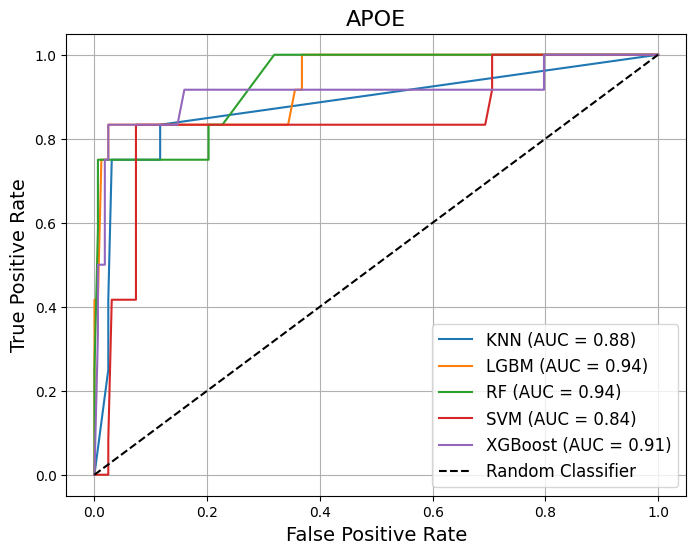

In [14]:
# %% ============================================================================
# Generate Comparison ROC-AUC Curves for Each Protein Target
# ============================================================================

# Figure for Apolipoprotein E (APOE)
#Initiate Figure
plt.figure(figsize=(8, 6))

#Define Protein Target
X_test = X_test_full['APOE']
y_test = y_test_dict['APOE']

# Retrieve best estimators calculated for each model
LGBM_best_estimator = LGBM_results['APOE']['best_estimator']
RF_best_estimator  = RF_results['APOE']['best_estimator']
KNN_best_estimator = KNN_results['APOE']['best_estimator']
SVM_best_estimator = SVM_results['APOE']['best_estimator']
XGBoost_best_estimator = XGBoost_results['APOE']['best_estimator']

# Run ML prediction for target
y_pred_LGBM_APOE = LGBM_best_estimator.predict(X_test)
y_prob_LGBM_APOE = LGBM_best_estimator.predict_proba(X_test)[:, 1]

y_pred_RF_APOE = RF_best_estimator.predict(X_test)
y_prob_RF_APOE = RF_best_estimator.predict_proba(X_test)[:, 1]

y_pred_KNN_APOE = KNN_best_estimator.predict(X_test)
y_prob_KNN_APOE = KNN_best_estimator.predict_proba(X_test)[:, 1]

y_pred_SVM_APOE = SVM_best_estimator.predict(X_test)
y_prob_SVM_APOE = SVM_best_estimator.predict_proba(X_test)[:, 1]

y_pred_XGBoost_APOE = XGBoost_best_estimator.predict(X_test)
y_prob_XGBoost_APOE = XGBoost_best_estimator.predict_proba(X_test)[:, 1]

# Compute ROC-AUC for target
roc_auc_LGBM_APOE = roc_auc_score(y_test, y_prob_LGBM_APOE)
roc_auc_RF_APOE  = roc_auc_score(y_test, y_prob_RF_APOE)
roc_auc_KNN_APOE = roc_auc_score(y_test, y_prob_KNN_APOE)
roc_auc_SVM_APOE = roc_auc_score(y_test, y_prob_SVM_APOE)
roc_auc_XGBoost_APOE = roc_auc_score(y_test, y_prob_XGBoost_APOE)

# Display Results
print('-------------------------------')
print('ROC-AUC Scores for APOE')
print('-------------------------------')
print(roc_auc_KNN_APOE)
print(roc_auc_LGBM_APOE)
print(roc_auc_RF_APOE)
print(roc_auc_SVM_APOE)
print(roc_auc_XGBoost_APOE)
 # Add KNN APOE ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob_KNN_APOE)
plt.plot(fpr, tpr, label=f'KNN (AUC = {roc_auc_KNN_APOE:.2f})')

# Add LGBM APOE ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob_LGBM_APOE)
plt.plot(fpr, tpr, label=f'LGBM (AUC = {roc_auc_LGBM_APOE:.2f})')

# Add RF APOE ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob_RF_APOE)
plt.plot(fpr, tpr, label=f'RF (AUC = {roc_auc_RF_APOE:.2f})')

# Add SVM APOE ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob_SVM_APOE)
plt.plot(fpr, tpr, label=f'SVM (AUC = {roc_auc_SVM_APOE:.2f})')

#Add XGBoost APOE ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob_XGBoost_APOE)
plt.plot(fpr, tpr, label=f'XGBoost (AUC = {roc_auc_XGBoost_APOE:.2f})')

# Add labels, title, and legend to the figure
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')  # Random classifier line
plt.title('APOE', fontsize=16)
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.legend(loc="lower right", fontsize=12)
plt.grid(True)
plt.show()

-------------------------------
ROC-AUC Scores for APOB-100
-------------------------------
0.9196581196581197
0.9365811965811965
0.9123076923076923
0.8123076923076924
0.8968376068376068


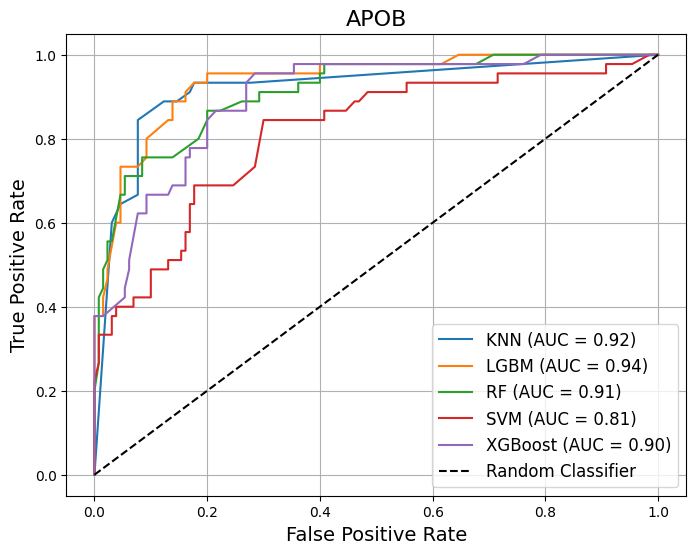

In [15]:
# Figure for Apolipoprotein B-100 (APOB)
#Initiate Figure
plt.figure(figsize=(8, 6))

#Define Protein Target
X_test = X_test_full['APOB']
y_test = y_test_dict['APOB']

# Retrieve best estimators calculated for each model
LGBM_best_estimator = LGBM_results['APOB']['best_estimator']
RF_best_estimator  = RF_results['APOB']['best_estimator']
KNN_best_estimator = KNN_results['APOB']['best_estimator']
SVM_best_estimator = SVM_results['APOB']['best_estimator']
XGBoost_best_estimator = XGBoost_results['APOB']['best_estimator']

# Run ML prediction for target
y_pred_LGBM_APOB = LGBM_best_estimator.predict(X_test)
y_prob_LGBM_APOB = LGBM_best_estimator.predict_proba(X_test)[:, 1]

y_pred_RF_APOB = RF_best_estimator.predict(X_test)
y_prob_RF_APOB = RF_best_estimator.predict_proba(X_test)[:, 1]

y_pred_KNN_APOB = KNN_best_estimator.predict(X_test)
y_prob_KNN_APOB = KNN_best_estimator.predict_proba(X_test)[:, 1]

y_pred_SVM_APOB = SVM_best_estimator.predict(X_test)
y_prob_SVM_APOB = SVM_best_estimator.predict_proba(X_test)[:, 1]

y_pred_XGBoost_APOB = XGBoost_best_estimator.predict(X_test)
y_prob_XGBoost_APOB = XGBoost_best_estimator.predict_proba(X_test)[:, 1]

# Compute ROC-AUC for target
roc_auc_LGBM_APOB = roc_auc_score(y_test, y_prob_LGBM_APOB)
roc_auc_RF_APOB   = roc_auc_score(y_test, y_prob_RF_APOB)
roc_auc_KNN_APOB  = roc_auc_score(y_test, y_prob_KNN_APOB)
roc_auc_SVM_APOB  = roc_auc_score(y_test, y_prob_SVM_APOB)
roc_auc_XGBoost_APOB = roc_auc_score(y_test, y_prob_XGBoost_APOB)

# Display results
print('-------------------------------')
print('ROC-AUC Scores for APOB-100')
print('-------------------------------')
print(roc_auc_KNN_APOB)
print(roc_auc_LGBM_APOB)
print(roc_auc_RF_APOB)
print(roc_auc_SVM_APOB)
print(roc_auc_XGBoost_APOB)

# Add KNN APOB ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob_KNN_APOB)
plt.plot(fpr, tpr, label=f'KNN (AUC = {roc_auc_KNN_APOB:.2f})')

# Add LGBM APOB ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob_LGBM_APOB)
plt.plot(fpr, tpr, label=f'LGBM (AUC = {roc_auc_LGBM_APOB:.2f})')

# Add RF APOB ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob_RF_APOB)
plt.plot(fpr, tpr, label=f'RF (AUC = {roc_auc_RF_APOB:.2f})')

# Add SVM APOB ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob_SVM_APOB)
plt.plot(fpr, tpr, label=f'SVM (AUC = {roc_auc_SVM_APOB:.2f})')

#Add XGBoost APOB ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob_XGBoost_APOB)
plt.plot(fpr, tpr, label=f'XGBoost (AUC = {roc_auc_XGBoost_APOB:.2f})')

# Add labels, title, and legend to the figure
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')  # Random classifier line
plt.title('APOB', fontsize=16)
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.legend(loc="lower right", fontsize=12)
plt.grid(True)
plt.show()



-------------------------------
ROC-AUC Scores for CO3
-------------------------------
0.9627742946708463
0.9738766980146291
0.9413531870428422
0.9194096133751307
0.9481452455590387


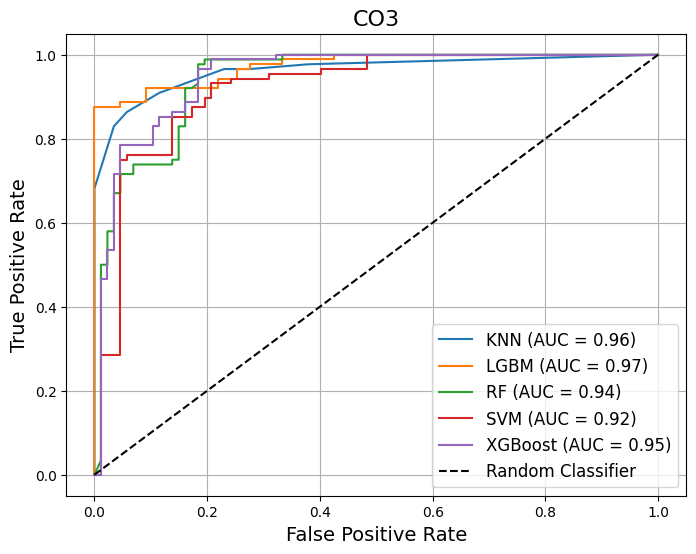

In [16]:
# Figure for Complement Component C3 (CO3)
#Initiate figure
plt.figure(figsize=(8, 6))

#Define protein target
X_test = X_test_full['CO3']
y_test = y_test_dict['CO3']

# Retrieve best estimators calculated for each model
LGBM_best_estimator = LGBM_results['CO3']['best_estimator']
RF_best_estimator  = RF_results['CO3']['best_estimator']
KNN_best_estimator = KNN_results['CO3']['best_estimator']
SVM_best_estimator = SVM_results['CO3']['best_estimator']
XGBoost_best_estimator = XGBoost_results['CO3']['best_estimator']

# Run ML prediction for target
y_pred_LGBM_CO3 = LGBM_best_estimator.predict(X_test)
y_prob_LGBM_CO3 = LGBM_best_estimator.predict_proba(X_test)[:, 1]

y_pred_RF_CO3 = RF_best_estimator.predict(X_test)
y_prob_RF_CO3 = RF_best_estimator.predict_proba(X_test)[:, 1]

y_pred_KNN_CO3 = KNN_best_estimator.predict(X_test)
y_prob_KNN_CO3 = KNN_best_estimator.predict_proba(X_test)[:, 1]

y_pred_SVM_CO3 = SVM_best_estimator.predict(X_test)
y_prob_SVM_CO3 = SVM_best_estimator.predict_proba(X_test)[:, 1]

y_pred_XGBoost_CO3 = XGBoost_best_estimator.predict(X_test)
y_prob_XGBoost_CO3 = XGBoost_best_estimator.predict_proba(X_test)[:, 1]

# Compute ROC-AUC for target
roc_auc_KNN_CO3 = roc_auc_score(y_test, y_prob_KNN_CO3)
roc_auc_LGBM_CO3 = roc_auc_score(y_test, y_prob_LGBM_CO3)
roc_auc_RF_CO3  = roc_auc_score(y_test, y_prob_RF_CO3)
roc_auc_SVM_CO3 = roc_auc_score(y_test, y_prob_SVM_CO3)
roc_auc_XGBoost_CO3 = roc_auc_score(y_test, y_prob_XGBoost_CO3)

# Display Result
print('-------------------------------')
print('ROC-AUC Scores for CO3')
print('-------------------------------')
print(roc_auc_KNN_CO3)
print(roc_auc_LGBM_CO3)
print(roc_auc_RF_CO3)
print(roc_auc_SVM_CO3)
print(roc_auc_XGBoost_CO3)

# Add KNN CO3 ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob_KNN_CO3)
plt.plot(fpr, tpr, label=f'KNN (AUC = {roc_auc_KNN_CO3:.2f})')

# Add LGBM CO3 ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob_LGBM_CO3)
plt.plot(fpr, tpr, label=f'LGBM (AUC = {roc_auc_LGBM_CO3:.2f})')

# Add RF CO3 ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob_RF_CO3)
plt.plot(fpr, tpr, label=f'RF (AUC = {roc_auc_RF_CO3:.2f})')

# Add SVM CO3 ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob_SVM_CO3)
plt.plot(fpr, tpr, label=f'SVM (AUC = {roc_auc_SVM_CO3:.2f})')

# Add XGBoost CO3 ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob_XGBoost_CO3)
plt.plot(fpr, tpr, label=f'XGBoost (AUC = {roc_auc_XGBoost_CO3:.2f})')

# Add labels, title, and legend to the figure
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')  # Random classifier line
plt.title('CO3', fontsize=16)
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.legend(loc="lower right", fontsize=12)
plt.grid(True)
plt.show()


-------------------------------
ROC-AUC Scores for CLUS
-------------------------------
0.9443193193193193
0.9728478478478478
0.9388138138138138
0.95508008008008
0.9640890890890891


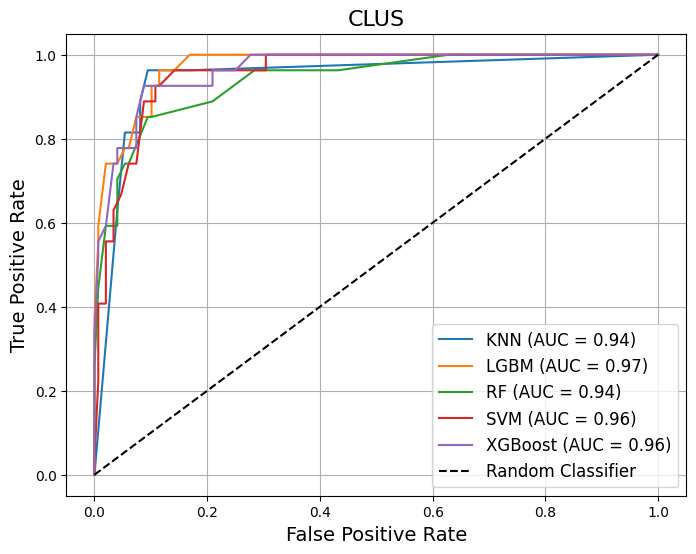

In [17]:
# Figure for Clustering (CLUS)
#Initiate figure
plt.figure(figsize=(8, 6))

# Define protein target
X_test = X_test_full['CLUS']
y_test = y_test_dict['CLUS']

# Retrieve best estimators calculated for each model
LGBM_best_estimator = LGBM_results['CLUS']['best_estimator']
RF_best_estimator  = RF_results['CLUS']['best_estimator']
KNN_best_estimator = KNN_results['CLUS']['best_estimator']
SVM_best_estimator = SVM_results['CLUS']['best_estimator']
XGBoost_best_estimator = XGBoost_results['CLUS']['best_estimator']

# Run ML prediction for target
y_pred_LGBM_CLUS = LGBM_best_estimator.predict(X_test)
y_prob_LGBM_CLUS = LGBM_best_estimator.predict_proba(X_test)[:, 1]

y_pred_RF_CLUS = RF_best_estimator.predict(X_test)
y_prob_RF_CLUS = RF_best_estimator.predict_proba(X_test)[:, 1]

y_pred_KNN_CLUS = KNN_best_estimator.predict(X_test)
y_prob_KNN_CLUS = KNN_best_estimator.predict_proba(X_test)[:, 1]

y_pred_SVM_CLUS = SVM_best_estimator.predict(X_test)
y_prob_SVM_CLUS = SVM_best_estimator.predict_proba(X_test)[:, 1]

y_pred_XGBoost_CLUS = XGBoost_best_estimator.predict(X_test)
y_prob_XGBoost_CLUS = XGBoost_best_estimator.predict_proba(X_test)[:, 1]

# Compute ROC-AUC for target
roc_auc_LGBM_CLUS = roc_auc_score(y_test, y_prob_LGBM_CLUS)
roc_auc_RF_CLUS  = roc_auc_score(y_test, y_prob_RF_CLUS)
roc_auc_KNN_CLUS = roc_auc_score(y_test, y_prob_KNN_CLUS)
roc_auc_SVM_CLUS = roc_auc_score(y_test, y_prob_SVM_CLUS)
roc_auc_XGBoost_CLUS = roc_auc_score(y_test, y_prob_XGBoost_CLUS)

# Display Results
print('-------------------------------')
print('ROC-AUC Scores for CLUS')
print('-------------------------------')
print(roc_auc_KNN_CLUS)
print(roc_auc_LGBM_CLUS)
print(roc_auc_RF_CLUS)
print(roc_auc_SVM_CLUS)
print(roc_auc_XGBoost_CLUS)

# Add KNN CLUS ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob_KNN_CLUS)
plt.plot(fpr, tpr, label=f'KNN (AUC = {roc_auc_KNN_CLUS:.2f})')

# Add LGBM CLUS ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob_LGBM_CLUS)
plt.plot(fpr, tpr, label=f'LGBM (AUC = {roc_auc_LGBM_CLUS:.2f})')

# Add RF CLUS ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob_RF_CLUS)
plt.plot(fpr, tpr, label=f'RF (AUC = {roc_auc_RF_CLUS:.2f})')

# Add SVM CLUS ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob_SVM_CLUS)
plt.plot(fpr, tpr, label=f'SVM (AUC = {roc_auc_SVM_CLUS:.2f})')

# Add XGBoost CLUS ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob_XGBoost_CLUS)
plt.plot(fpr, tpr, label=f'XGBoost (AUC = {roc_auc_XGBoost_CLUS:.2f})')

# Add labels, title, and legend to the figure
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')  # Random classifier line
plt.title('CLUS', fontsize=16)
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.legend(loc="lower right", fontsize=12)
plt.grid(True)
plt.show()

In [18]:
# %% ============================================================================
# Make Prediction Based on User Input Features!
# Important: Above models MUST be run first before tool can be used
# ============================================================================

def protein_predict(model_lookup_dict, target, model_name, raw_input_dict):
    model_results_dict = model_lookup_dict[model_name]

    for col, mapping in encoding_mappings.items():
        if col in raw_input_dict:
            raw_input_dict[col] = mapping.get(raw_input_dict[col], raw_input_dict[col])

    df_input = pd.DataFrame([raw_input_dict])
    df_input_encoded = pd.get_dummies(df_input)
    for col in X.columns:
        if col not in df_input_encoded.columns:
            df_input_encoded[col] = 0
    df_input_encoded = df_input_encoded[X.columns]

    estimator = model_results_dict[target]['best_estimator']
    prediction = estimator.predict(df_input_encoded)[0]
    probability = estimator.predict_proba(df_input_encoded)[0][1]

    presence_text = "PRESENT" if prediction == 0 else "ABSENT"

    print(f"\n Prediction for target '{target}' using model '{model_name}':")
    print(f"The model predicts that **{target} will be {presence_text}** in the protein corona.")
    print(f"Confidence (probability of being PRESENT): {probability:.2%}")

# === INPUT NP FEATURES HERE  ===
NP_features = {
    # Encoded via mappings; use numerical encodding or nominal group
    'Size_Group': "50~100",           # Options: 0: "<50", 1: "50~100", 2: "100~150", 3: ">150"
    'ZP_Group': "-50~-10",          # Options: 0: "<-50", 1: "-50~-10", 2: "-10~+10", 3: "+10~+50", 4: ">+50"
    'In_Time': "30~60",             # Options: 0: "<30", 1: "30~60", 2: ">60"

    # One-hot encoded fields [binary: 0 (No/Absent) or 1 (Yes/Present)]
    # IMPORTANT: For each category group (Type, Subtype, ZP_Charge, etc.), only ONE field should be set to 1!
    # All others in the same group must be 0 — these represent mutually exclusive categories!
    #Type
    'Type_Carbon-Based':0,
    'Type_Inorganic': 0,
    'Type_Organic': 1,

    #Subtype
    'Subtype_Carbon':0,
    'Subtype_DNA': 0,
    'Subtype_Latex': 0,
    'Subtype_Lipid': 0,
    'Subtype_Lipid-DNA': 0,
    'Subtype_Metal': 1,
    'Subtype_Metal Oxide': 0,
    'Subtype_Niosome': 0,
    'Subtype_Polystyrene': 0,
    'Subtype_Silica': 0,

    #Shaking/Agitation
    'Shaking_Y': 0, # Options: 0: "N", 1: "Y"

    #ZP Charge
    'ZP_Charge_Negative': 1,
    'ZP_Charge_Neutral': 0,
    'ZP_Charge_Positive': 0,

    #Modification Charge
    'Mod_Charge_Neutral': 0,
    'Mod_Charge_No Modification': 1,
    'Mod_Charge_Positive': 0,
    'Mod_Charge_Negative': 0,
}

# === SELECT MODEL AND TARGET ===
target_choice = 'CLUS'             # Choose from: 'APOE', 'APOB', 'CO3', 'CLUS'
model_choice = 'LGBM'           # Choose from: 'KNN', 'LGBM', 'RF', 'SVM', 'XGBoost'

model_lookup = {
    'KNN': KNN_results,
    'LGBM': LGBM_results,
    'RF': RF_results,
    'SVM': SVM_results,
    'XGBoost': XGBoost_results
}

# === MAKE PREDICTION ===
protein_predict(model_lookup, target_choice, model_choice, NP_features)



 Prediction for target 'CLUS' using model 'LGBM':
The model predicts that **CLUS will be PRESENT** in the protein corona.
Confidence (probability of being PRESENT): 34.95%
